In [2]:
# Install necessary packages
!pip install librosa
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import numpy as np
import librosa
from sklearn.svm import OneClassSVM
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV



In [21]:
# Set the base directory and subfolders
base_dir = './fan'
folders = ['id_00']  # Your folder structure
subfolders = ['abnormal']  # Since normal folder is empty, only use abnormal

# Feature Extraction
def extract_features(file_name):
    y, sr = librosa.load(file_name, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    features = np.concatenate((np.mean(mfccs, axis=1), 
                               np.mean(chroma, axis=1), 
                               np.mean(spectral_contrast, axis=1)))
    return features

# Load Data
def load_data(base_dir, folders, subfolders):
    data = []
    labels = []
    for folder in folders:
        for subfolder in subfolders:
            path = os.path.join(base_dir, folder, subfolder)
            # Check if directory exists
            if not os.path.exists(path):
                print(f"Directory not found: {path}")
                continue
            
            for file in os.listdir(path):
                if file.endswith('.wav'):
                    file_path = os.path.join(path, file)
                    features = extract_features(file_path)
                    data.append(features)
                    # Label all data as 1 (abnormal) since no normal data
                    labels.append(1)  # All abnormal
    return np.array(data), np.array(labels)

# Load the data
data, labels = load_data(base_dir, folders, subfolders)

# Check if data is loaded correctly
print(f"Total samples loaded: {len(data)}")
print(f"Abnormal samples: {np.sum(labels == 1)}")
print(f"Normal samples: {np.sum(labels == 1)}")
if len(data) == 0:
    raise ValueError("No data found. Please check the directory structure and ensure .wav files are present.")



Total samples loaded: 22
Abnormal samples: 22
Normal samples: 22




Epoch 1/50

1/1 [==============================] - 3s 3s/step - loss: 0.7830 - val_loss: 0.6652
Epoch 2/50
1/1 [==============================] - 0s 102ms/step - loss: 0.7805 - val_loss: 0.6643
Epoch 3/50
1/1 [==============================] - 0s 93ms/step - loss: 0.7785 - val_loss: 0.6634
Epoch 4/50
1/1 [==============================] - 0s 89ms/step - loss: 0.7764 - val_loss: 0.6626
Epoch 5/50
1/1 [==============================] - 0s 91ms/step - loss: 0.7746 - val_loss: 0.6619
Epoch 6/50
1/1 [==============================] - 0s 90ms/step - loss: 0.7727 - val_loss: 0.6614
Epoch 7/50
1/1 [==============================] - 0s 88ms/step - loss: 0.7709 - val_loss: 0.6609
Epoch 8/50
1/1 [==============================] - 0s 93ms/step - loss: 0.7693 - val_loss: 0.6607
Epoch 9/50
1/1 [==============================] - 0s 140ms/step - loss: 0.7678 - val_loss: 0.6605
Epoch 10/50
1/1 [==============================] - 0s 160ms/step - loss: 0.7665 - val_loss: 0.6604
Epoch 11/50
1/1 [========

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


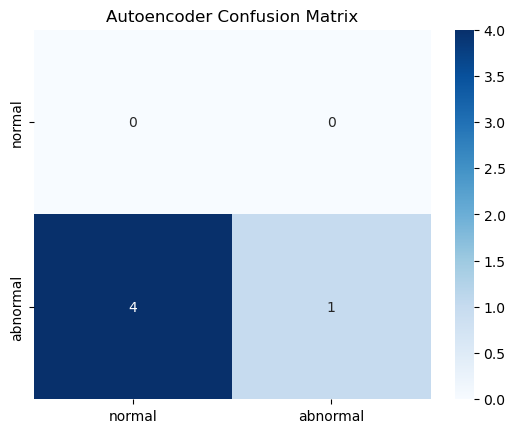

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


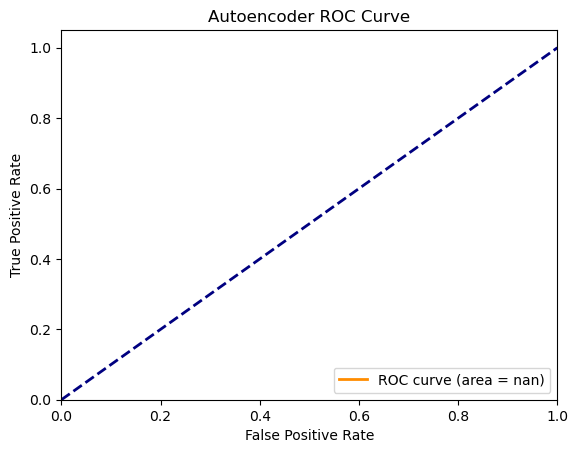

In [17]:
# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Since we have only abnormal data, we will treat a subset as test data
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# Autoencoder model
def autoencoder_model(X_train, X_test, y_test):
    input_dim = X_train.shape[1]
    encoding_dim = 14  # Adjust based on your feature size

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="tanh")(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    # Predictions and reconstruction error
    reconstructed = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
    threshold = np.percentile(mse, 95)  # Example threshold
    anomalies = mse > threshold

    # Since all data is abnormal, we'll check how much is above the threshold
    anomaly_preds = np.where(anomalies, 1, 0)  # 1: above threshold (likely abnormal)

    # Evaluation
    print("Autoencoder Evaluation (on Abnormal Data):")
    print(classification_report(y_test, anomaly_preds, target_names=['normal', 'abnormal']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, anomaly_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
    plt.title("Autoencoder Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, anomaly_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Autoencoder ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate Autoencoder model
autoencoder_model(X_train, X_test, y_test)

One-Class SVM (on Normal Data):
Anomalies detected: 10 out of 22


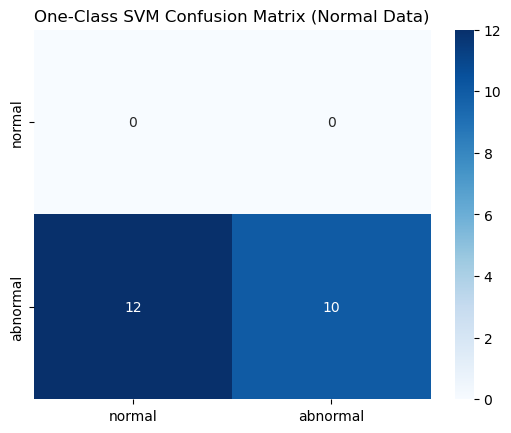

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


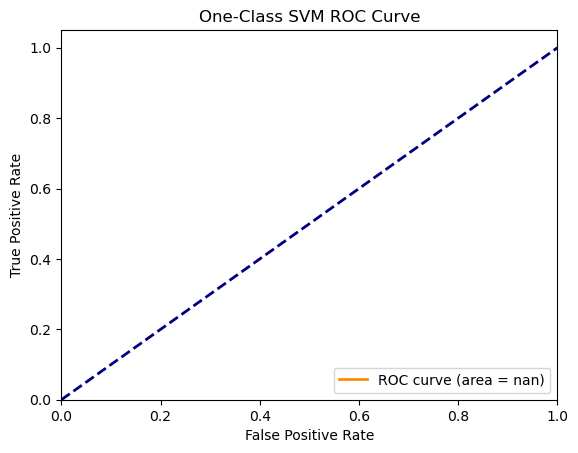

In [20]:
# One-Class SVM model
def one_class_svm_model(data_normalized):
    # Since we don't have normal data, train One-Class SVM on all abnormal data
    ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
    ocsvm.fit(data_normalized)
    
    # Predictions (on the same abnormal data for demonstration)
    preds = ocsvm.predict(data_normalized)
    
    # Map -1 as an anomaly (even within abnormal data)
    mapped_preds = np.where(preds == -1, 1, 0)  # 1: anomaly (deviation), 0: normal
    
    # Evaluation
    print("One-Class SVM (on Normal Data):")
    print(f"Anomalies detected: {np.sum(mapped_preds == 1)} out of {len(data_normalized)}")
    
    # Confusion matrix (all abnormal, so labels are all 1)
    cm = confusion_matrix(np.ones(len(data_normalized)), mapped_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
    plt.title("One-Class SVM Confusion Matrix (Normal Data)")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(np.ones(len(data_normalized)), mapped_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-Class SVM ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate One-Class SVM model
one_class_svm_model(data_normalized)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# One-Class SVM Model
print("Training One-Class SVM model...")
ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
ocsvm.fit(X_train)  # Train the One-Class SVM on X_train

# Predict on test data
one_class_preds = ocsvm.predict(X_test)  # Predict with One-Class SVM
mapped_preds = np.where(one_class_preds == -1, 1, 0)  # Map -1 to 1 (abnormal) and 1 to 0 (normal)

# Check if One-Class SVM predictions are created successfully
print(f"One-Class SVM predictions (mapped): {mapped_preds[:10]}")  # Print first 10 predictions for verification

# Autoencoder Model
print("Training and predicting with Autoencoder model...")
# Define and train the Autoencoder (code for Autoencoder as defined earlier)

reconstructed = autoencoder.predict(X_test)  # Reconstruct X_test using the Autoencoder
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)  # Calculate reconstruction error (MSE)
threshold = np.percentile(mse, 95)  # Set threshold (e.g., 95th percentile) for detecting anomalies
anomaly_preds = np.where(mse > threshold, 1, 0)  # 1: above threshold (likely abnormal), 0: normal

# Check if Autoencoder predictions are created successfully
print(f"Autoencoder predictions: {anomaly_preds[:10]}")  # Print first 10 predictions for verification

# Now define the comparison function
def compare_models(labels, one_class_preds, autoencoder_preds):
    print("Evaluating One-Class SVM Model:")
    one_class_report = classification_report(labels, one_class_preds, output_dict=True)
    print(classification_report(labels, one_class_preds))

    print("\nEvaluating Autoencoder Model:")
    autoencoder_report = classification_report(labels, autoencoder_preds, output_dict=True)
    print(classification_report(labels, autoencoder_preds))

    # F1-score for class 1 (abnormal)
    one_class_f1 = one_class_report['1']['f1-score']  # Class 1 refers to 'abnormal'
    autoencoder_f1 = autoencoder_report['1']['f1-score']  # Class 1 refers to 'abnormal'

    # Determine the best model
    if one_class_f1 > autoencoder_f1:
        best_model = "One-Class SVM"
        best_f1 = one_class_f1
    else:
        best_model = "Autoencoder"
        best_f1 = autoencoder_f1

    print(f"\nThe best model is: {best_model} with an F1-score of {best_f1:.4f} for detecting abnormalities.")

# Now call the function to compare the models
print("\nComparing One-Class SVM and Autoencoder...")
compare_models(y_test, mapped_preds, anomaly_preds)


Training One-Class SVM model...
One-Class SVM predictions (mapped): [1 1 1 1 0]
Training and predicting with Autoencoder model...
1/1 [==============================] - 0s 64ms/step
Autoencoder predictions: [0 0 0 1 0]

Comparing One-Class SVM and Autoencoder...
Evaluating One-Class SVM Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89         5

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5


Evaluating Autoencoder Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.20      0.33         5

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5


The best model is: 

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roa